# Benchmark artifact analysis (events + logs)

This notebook loads benchmark artifacts (`*.events.jsonl` and `*.logs.jsonl`) and plots signals that can grow over time. It defaults to the latest `benchmarks/*.events.jsonl` and the matching `*.logs.jsonl`.

If you are analyzing an older run, set `EVENTS_PATH` explicitly in the config cell.

In [13]:
from pathlib import Path
import json
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 4)


def find_repo_root(start: Path) -> Path:
    for path in [start, *start.parents]:
        if (path / "node").exists() and (
            (path / "benchmarks_hetzner").exists() or (path / "benchmarks").exists()
        ):
            return path
    return start


ROOT = find_repo_root(Path.cwd())
BENCH_DIR = ROOT / "benchmarks_hetzner"
if not BENCH_DIR.exists():
    BENCH_DIR = ROOT / "benchmarks"


def latest_file(pattern: str):
    files = sorted(BENCH_DIR.glob(pattern), key=lambda p: p.stat().st_mtime)
    return files[-1] if files else None


EVENTS_PATH = latest_file("events__*__tmp.jsonl")
if EVENTS_PATH is None:
    EVENTS_PATH = latest_file("*.events.jsonl")

LOGS_PATH = None
if EVENTS_PATH is not None:
    if EVENTS_PATH.name.startswith("events__") and EVENTS_PATH.name.endswith("__tmp.jsonl"):
        LOGS_PATH = EVENTS_PATH.with_name(EVENTS_PATH.name.replace("events__", "logs__"))
    else:
        LOGS_PATH = EVENTS_PATH.with_name(
            EVENTS_PATH.name.replace(".events.jsonl", ".logs.jsonl")
        )
    if LOGS_PATH is not None and not LOGS_PATH.exists():
        LOGS_PATH = None

BIN_S = 1  # bin size in seconds for aggregated series
EVENTS_PATH, LOGS_PATH

(PosixPath('/Users/vicnaum/github/stateless-history-node/benchmarks_hetzner/ingest_1M_v0_2_jemalloc__20260124T150045Z__range-23283452-24283451__chunk16__chunkmax64__inflight15__timeout5000__profile-release__alloc-jemalloc.events.jsonl'),
 PosixPath('/Users/vicnaum/github/stateless-history-node/benchmarks_hetzner/ingest_1M_v0_2_jemalloc__20260124T150045Z__range-23283452-24283451__chunk16__chunkmax64__inflight15__timeout5000__profile-release__alloc-jemalloc.logs.jsonl'))

In [14]:
def _bin_second(t_ms: int, bin_s: int) -> int:
    bin_ms = max(1, int(bin_s * 1000))
    return int(t_ms // bin_ms) * bin_s


def load_resources_from_logs(logs_path: Path):
    resources = []
    if logs_path is None or not logs_path.exists():
        return resources
    bad_lines = 0
    max_report = 5
    with logs_path.open("r") as f:
        for line_no, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                bad_lines += 1
                if bad_lines <= max_report:
                    print(f"Skipping malformed JSON in {logs_path} at line {line_no}")
                continue
            if obj.get("message") != "benchmark resources":
                continue
            fields = obj.get("fields", {})
            record = {"t_ms": obj.get("t_ms", 0)}
            for key in (
                "rss_kb",
                "swap_kb",
                "rss_anon_kb",
                "rss_file_kb",
                "rss_shmem_kb",
                "cpu_busy_pct",
                "cpu_iowait_pct",
                "disk_read_mib_s",
                "disk_write_mib_s",
                "status",
                "processed",
                "queue",
                "inflight",
                "failed",
                "peers_active",
                "peers_total",
                "head_block",
                "head_seen",
            ):
                if key in fields:
                    record[key] = fields[key]
            resources.append(record)
    if bad_lines:
        print(f"Skipped {bad_lines} malformed JSON lines in {logs_path}")
    return resources


def load_events(events_path: Path, bin_s: int = 1):
    resources = []
    scheduler = []
    db_writer = []
    compactions = []
    bins = {}
    counts = defaultdict(int)
    compaction_open = {}
    bad_lines = 0
    max_report = 5

    def bump(sec: int, key: str, value: float):
        if sec not in bins:
            bins[sec] = defaultdict(float)
        bins[sec][key] += value

    if events_path is None or not events_path.exists():
        return resources, scheduler, db_writer, compactions, bins, counts

    with events_path.open("r") as f:
        for line_no, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                bad_lines += 1
                if bad_lines <= max_report:
                    print(f"Skipping malformed JSON in {events_path} at line {line_no}")
                continue
            event = obj.get("event")
            counts[event] += 1
            t_ms = int(obj.get("t_ms", 0))
            sec = _bin_second(t_ms, bin_s)

            if event == "resources_sample":
                resources.append(obj)
                continue
            if event == "scheduler_gauge_sample":
                scheduler.append(obj)
                continue
            if event == "db_writer_gauge_sample":
                db_writer.append(obj)
                continue

            if event == "peer_connected":
                bump(sec, "peer_connected", 1)
                continue
            if event == "peer_disconnected":
                bump(sec, "peer_disconnected", 1)
                continue
            if event == "peer_banned":
                bump(sec, "peer_banned", 1)
                continue
            if event == "peer_unbanned":
                bump(sec, "peer_unbanned", 1)
                continue

            if event == "fetch_end":
                blocks = int(obj.get("blocks", 0))
                missing = int(obj.get("missing_blocks", 0))
                bytes_total = (
                    int(obj.get("bytes_headers", 0))
                    + int(obj.get("bytes_bodies", 0))
                    + int(obj.get("bytes_receipts", 0))
                )
                bump(sec, "fetch_blocks", blocks - missing)
                bump(sec, "fetch_missing", missing)
                bump(sec, "fetch_bytes", bytes_total)
                bump(sec, "fetch_batches", 1)
                bump(sec, "fetch_dur_ms", int(obj.get("duration_ms", 0)))
                continue
            if event == "fetch_timeout":
                bump(sec, "fetch_timeouts", 1)
                continue
            if event == "process_end":
                bump(sec, "processed_blocks", 1)
                bump(sec, "processed_logs", int(obj.get("logs", 0)))
                bump(sec, "process_dur_us", int(obj.get("duration_us", 0)))
                continue
            if event == "db_flush_end":
                bump(sec, "db_blocks", int(obj.get("blocks", 0)))
                bump(sec, "db_bytes", int(obj.get("bytes_total", 0)))
                bump(sec, "db_flushes", 1)
                bump(sec, "db_flush_ms", int(obj.get("duration_ms", 0)))
                continue
            if event == "compaction_start":
                shard_start = obj.get("shard_start")
                compaction_open[("shard", shard_start)] = t_ms
                continue
            if event == "compaction_end":
                shard_start = obj.get("shard_start")
                start_ms = compaction_open.pop(("shard", shard_start), None)
                compactions.append(
                    {
                        "kind": "shard",
                        "shard_start": shard_start,
                        "start_ms": start_ms,
                        "end_ms": t_ms,
                        "duration_ms": None if start_ms is None else t_ms - start_ms,
                    }
                )
                continue
            if event == "compact_all_dirty_start":
                compaction_open[("compact_all_dirty", None)] = t_ms
                continue
            if event == "compact_all_dirty_end":
                start_ms = compaction_open.pop(("compact_all_dirty", None), None)
                compactions.append(
                    {
                        "kind": "compact_all_dirty",
                        "shard_start": None,
                        "start_ms": start_ms,
                        "end_ms": t_ms,
                        "duration_ms": None if start_ms is None else t_ms - start_ms,
                    }
                )
                continue
            if event == "seal_completed_start":
                compaction_open[("seal_completed", None)] = t_ms
                continue
            if event == "seal_completed_end":
                start_ms = compaction_open.pop(("seal_completed", None), None)
                compactions.append(
                    {
                        "kind": "seal_completed",
                        "shard_start": None,
                        "start_ms": start_ms,
                        "end_ms": t_ms,
                        "duration_ms": None if start_ms is None else t_ms - start_ms,
                    }
                )
                continue

    if bad_lines:
        print(f"Skipped {bad_lines} malformed JSON lines in {events_path}")
    return resources, scheduler, db_writer, compactions, bins, counts


def bins_to_df(bins: dict, bin_s: int):
    if not bins:
        return pd.DataFrame()
    rows = []
    for sec in sorted(bins.keys()):
        row = {"t_s": sec}
        row.update(bins[sec])
        rows.append(row)
    df = pd.DataFrame(rows).fillna(0)

    for col in (
        "fetch_bytes",
        "db_bytes",
        "process_dur_us",
        "processed_blocks",
        "fetch_dur_ms",
        "fetch_batches",
        "db_flush_ms",
        "db_flushes",
        "fetch_blocks",
        "db_blocks",
        "processed_logs",
        "fetch_missing",
        "fetch_timeouts",
        "peer_connected",
        "peer_disconnected",
        "peer_banned",
        "peer_unbanned",
    ):
        if col not in df.columns:
            df[col] = 0

    df["fetch_mib_s"] = df["fetch_bytes"] / (1024 * 1024) / max(1, bin_s)
    df["db_mib_s"] = df["db_bytes"] / (1024 * 1024) / max(1, bin_s)
    df["process_avg_ms"] = (
        df["process_dur_us"] / 1000.0 / df["processed_blocks"].replace(0, pd.NA)
    )
    df["fetch_avg_ms"] = (
        df["fetch_dur_ms"] / df["fetch_batches"].replace(0, pd.NA)
    )
    df["db_flush_avg_ms"] = (
        df["db_flush_ms"] / df["db_flushes"].replace(0, pd.NA)
    )
    df[["process_avg_ms", "fetch_avg_ms", "db_flush_avg_ms"]] = df[
        ["process_avg_ms", "fetch_avg_ms", "db_flush_avg_ms"]
    ].fillna(0)

    per_s = max(1, bin_s)
    df["fetch_blocks_s"] = df["fetch_blocks"] / per_s
    df["processed_blocks_s"] = df["processed_blocks"] / per_s
    df["db_blocks_s"] = df["db_blocks"] / per_s

    df["peer_connected_s"] = df["peer_connected"] / per_s
    df["peer_disconnected_s"] = df["peer_disconnected"] / per_s
    df["peer_banned_s"] = df["peer_banned"] / per_s
    df["peer_unbanned_s"] = df["peer_unbanned"] / per_s

    df["peer_connected_cum"] = df["peer_connected"].cumsum()
    df["peer_disconnected_cum"] = df["peer_disconnected"].cumsum()
    df["peer_banned_cum"] = df["peer_banned"].cumsum()
    df["peer_unbanned_cum"] = df["peer_unbanned"].cumsum()

    df["cum_fetch_blocks"] = df["fetch_blocks"].cumsum()
    df["cum_processed_blocks"] = df["processed_blocks"].cumsum()
    df["cum_db_blocks"] = df["db_blocks"].cumsum()
    df["backlog_fetch_minus_process"] = df["cum_fetch_blocks"] - df["cum_processed_blocks"]
    df["backlog_process_minus_write"] = df["cum_processed_blocks"] - df["cum_db_blocks"]
    return df

In [15]:
resources, scheduler, db_writer, compactions, bins, event_counts = load_events(EVENTS_PATH, BIN_S)

if not resources:
    resources = load_resources_from_logs(LOGS_PATH)

resources_df = pd.DataFrame(resources)
if not resources_df.empty:
    resources_df["t_s"] = resources_df["t_ms"] / 1000.0
    resources_df["rss_gib"] = resources_df["rss_kb"] / (1024 * 1024)
    resources_df["swap_gib"] = resources_df["swap_kb"] / (1024 * 1024)
    resources_df["rss_anon_gib"] = resources_df.get("rss_anon_kb", 0) / (1024 * 1024)
    resources_df["rss_file_gib"] = resources_df.get("rss_file_kb", 0) / (1024 * 1024)
    resources_df["rss_shmem_gib"] = resources_df.get("rss_shmem_kb", 0) / (1024 * 1024)

scheduler_df = pd.DataFrame(scheduler)
if not scheduler_df.empty:
    scheduler_df["t_s"] = scheduler_df["t_ms"] / 1000.0

db_writer_df = pd.DataFrame(db_writer)
if not db_writer_df.empty:
    db_writer_df["t_s"] = db_writer_df["t_ms"] / 1000.0

compactions_df = pd.DataFrame(compactions)
if not compactions_df.empty:
    compactions_df["start_s"] = compactions_df["start_ms"] / 1000.0
    compactions_df["end_s"] = compactions_df["end_ms"] / 1000.0

bins_df = bins_to_df(bins, BIN_S)

print("events:", EVENTS_PATH)
print("logs:", LOGS_PATH)
print("event types:", dict(sorted(event_counts.items())))
resources_df.head()

events: /Users/vicnaum/github/stateless-history-node/benchmarks_hetzner/ingest_1M_v0_2_jemalloc__20260124T150045Z__range-23283452-24283451__chunk16__chunkmax64__inflight15__timeout5000__profile-release__alloc-jemalloc.events.jsonl
logs: /Users/vicnaum/github/stateless-history-node/benchmarks_hetzner/ingest_1M_v0_2_jemalloc__20260124T150045Z__range-23283452-24283451__chunk16__chunkmax64__inflight15__timeout5000__profile-release__alloc-jemalloc.logs.jsonl
event types: {'batch_assigned': 118206, 'compact_all_dirty_end': 1, 'compact_all_dirty_start': 1, 'compaction_end': 101, 'compaction_start': 101, 'db_flush_end': 1954, 'db_flush_start': 1954, 'db_writer_gauge_sample': 141, 'fetch_end': 118134, 'fetch_start': 118206, 'fetch_timeout': 14, 'peer_banned': 18, 'peer_connected': 78, 'peer_disconnected': 20, 'peer_unbanned': 15, 'process_end': 1000000, 'process_start': 1000000, 'resources_sample': 1417, 'scheduler_gauge_sample': 142, 'seal_completed_end': 1, 'seal_completed_start': 1}


,t_ms,event,rss_kb,swap_kb,rss_anon_kb,rss_file_kb,rss_shmem_kb,cpu_busy_pct,cpu_iowait_pct,disk_read_mib_s,...,peers_active,peers_total,head_block,head_seen,t_s,rss_gib,swap_gib,rss_anon_gib,rss_file_gib,rss_shmem_gib
0,0,resources_sample,45964,0,31760,14204,0,0.000000,0.000000,0.0,...,0,0,0,24305410,0.0,0.043835,0.0,0.030289,0.013546,0.0
1,1000,resources_sample,310304,0,295972,14332,0,14.774624,0.083472,0.0,...,8,9,23284015,24305410,1.0,0.295929,0.0,0.282261,0.013668,0.0
2,2000,resources_sample,471972,0,457384,14588,0,20.303286,0.000000,0.0,...,8,9,23284600,24305410,2.0,0.450108,0.0,0.436195,0.013912,0.0
3,3000,resources_sample,575948,0,561360,14588,0,20.033529,0.000000,0.0,...,8,9,23285138,24305410,3.0,0.549267,0.0,0.535355,0.013912,0.0
4,4000,resources_sample,611160,0,596572,14588,0,19.849875,0.083403,0.0,...,8,9,23285695,24305410,4.0,0.582848,0.0,0.568935,0.013912,0.0


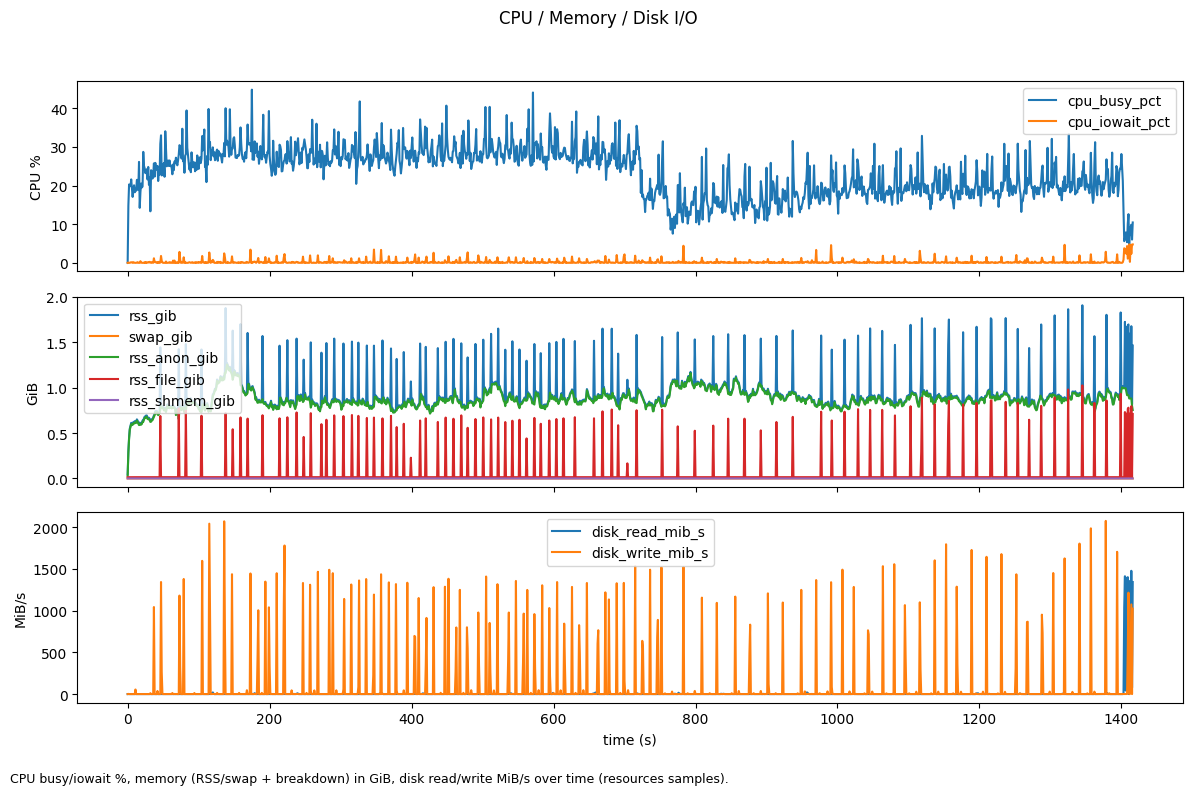

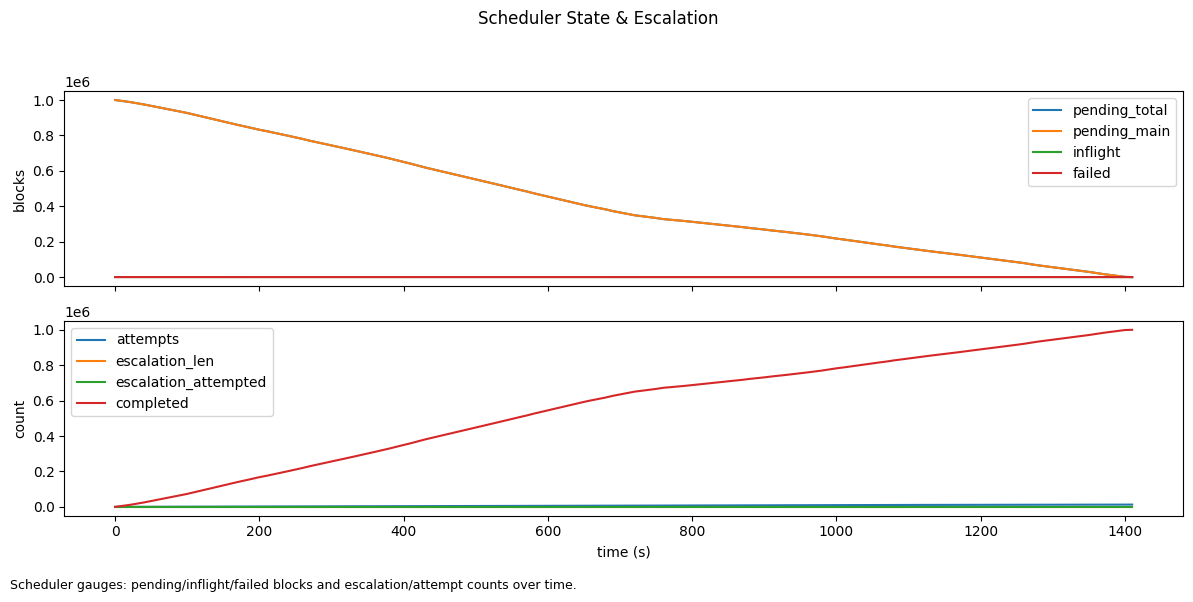

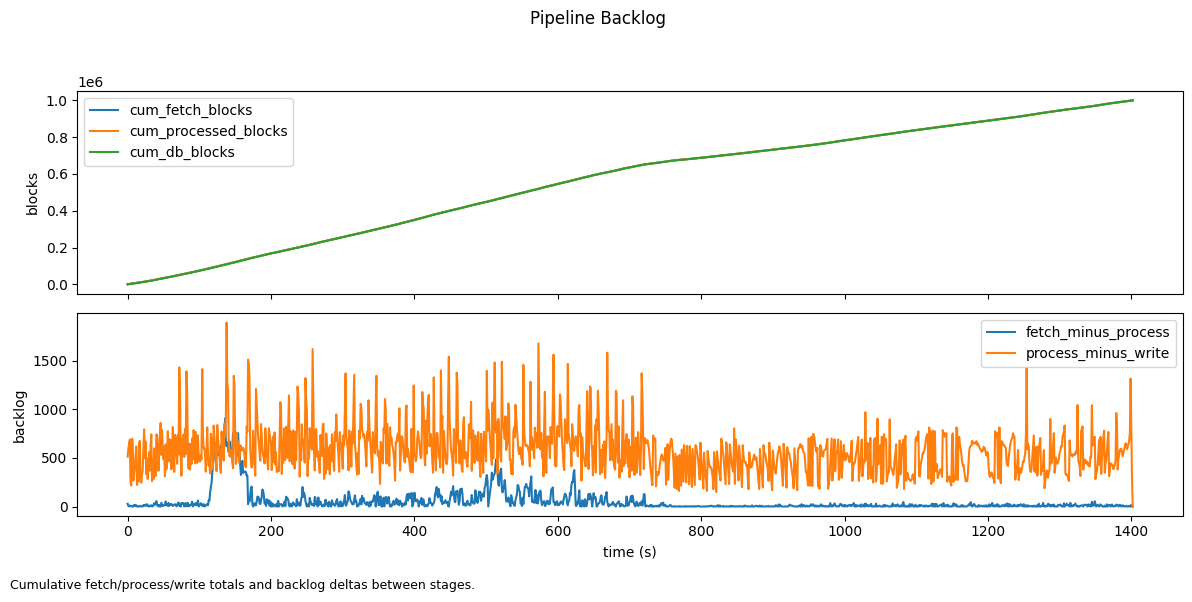

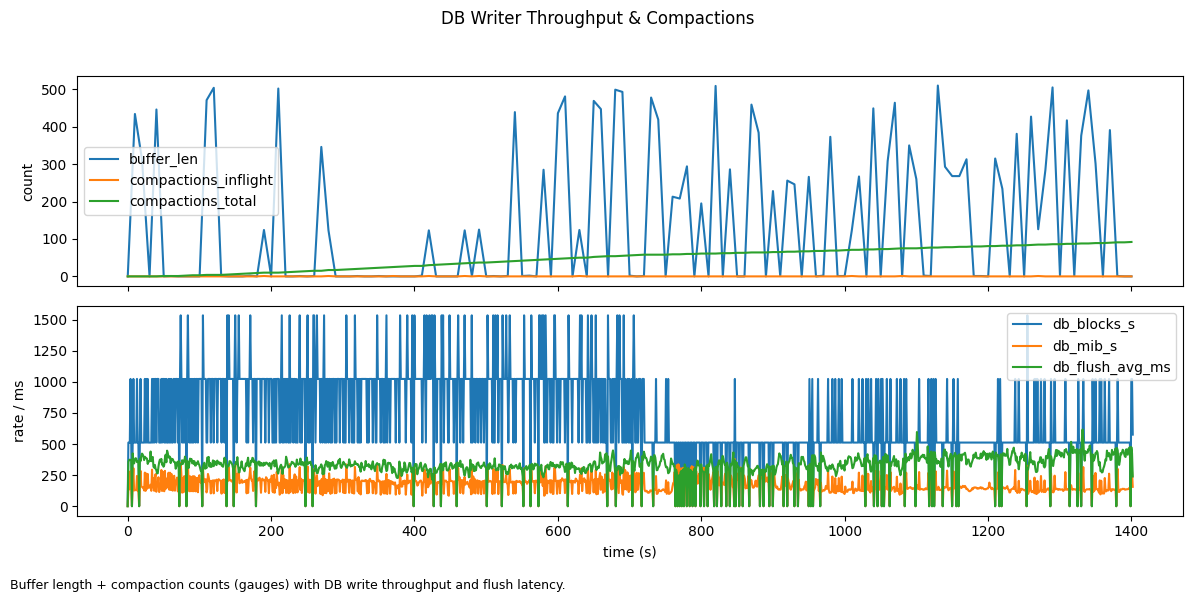

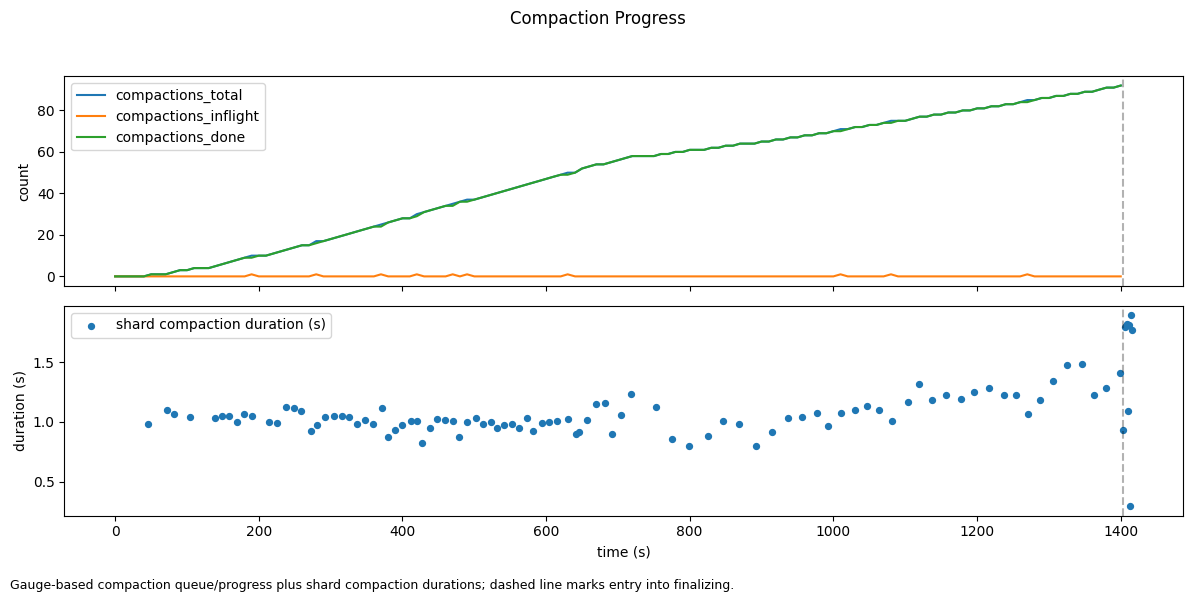

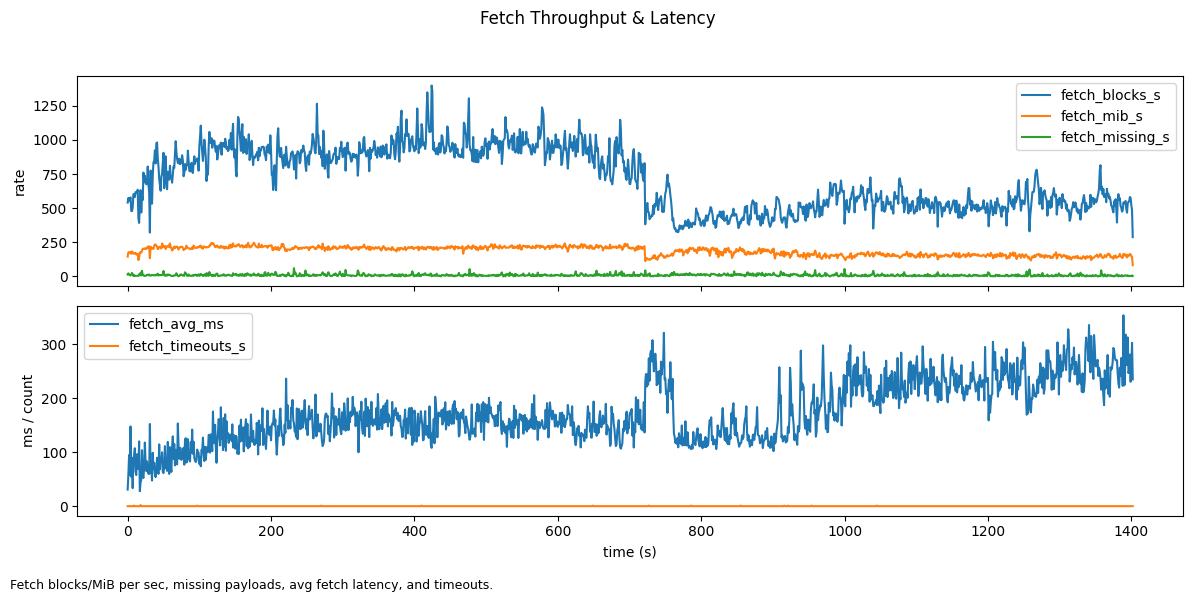

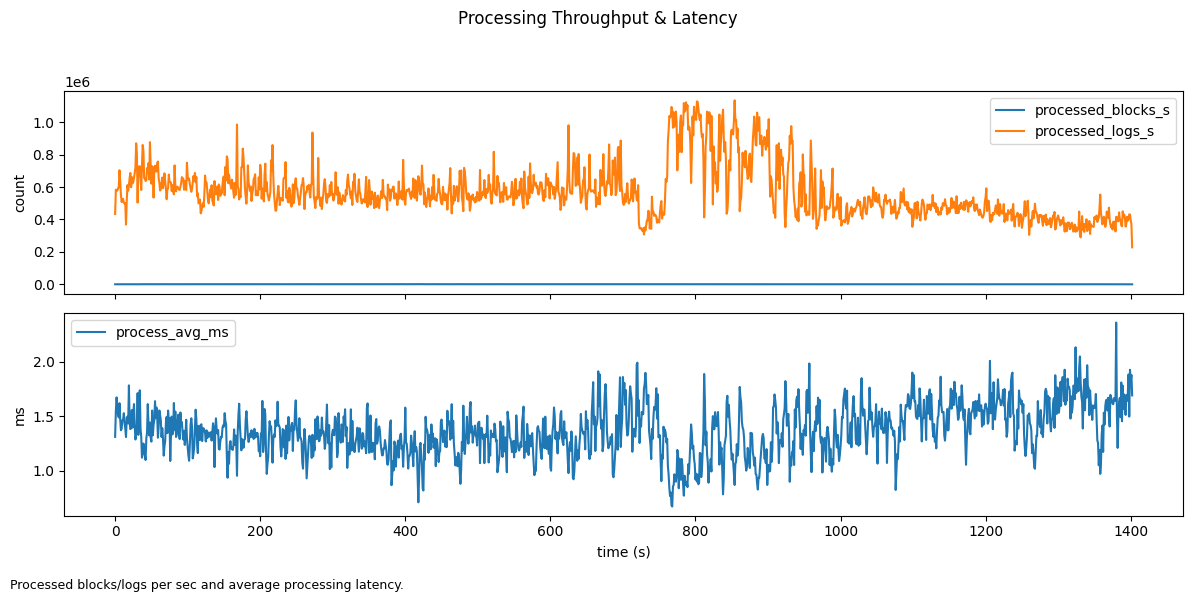

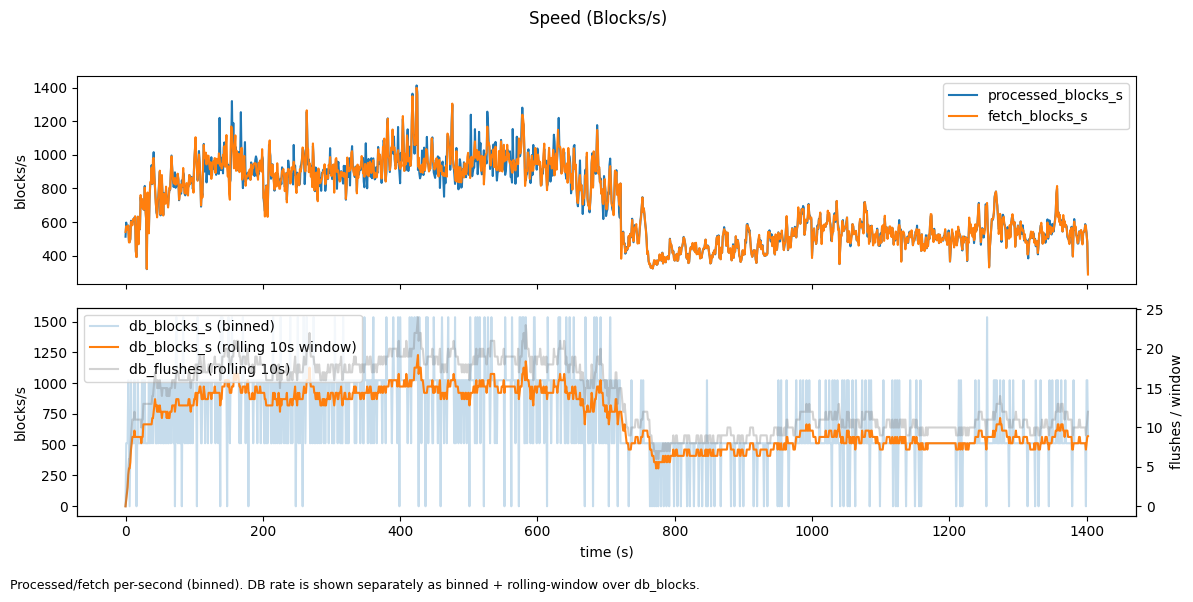

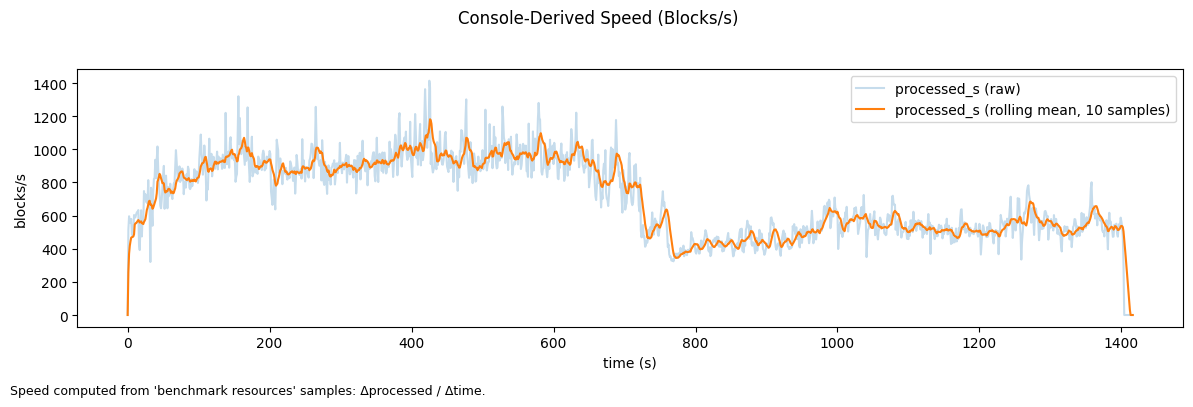

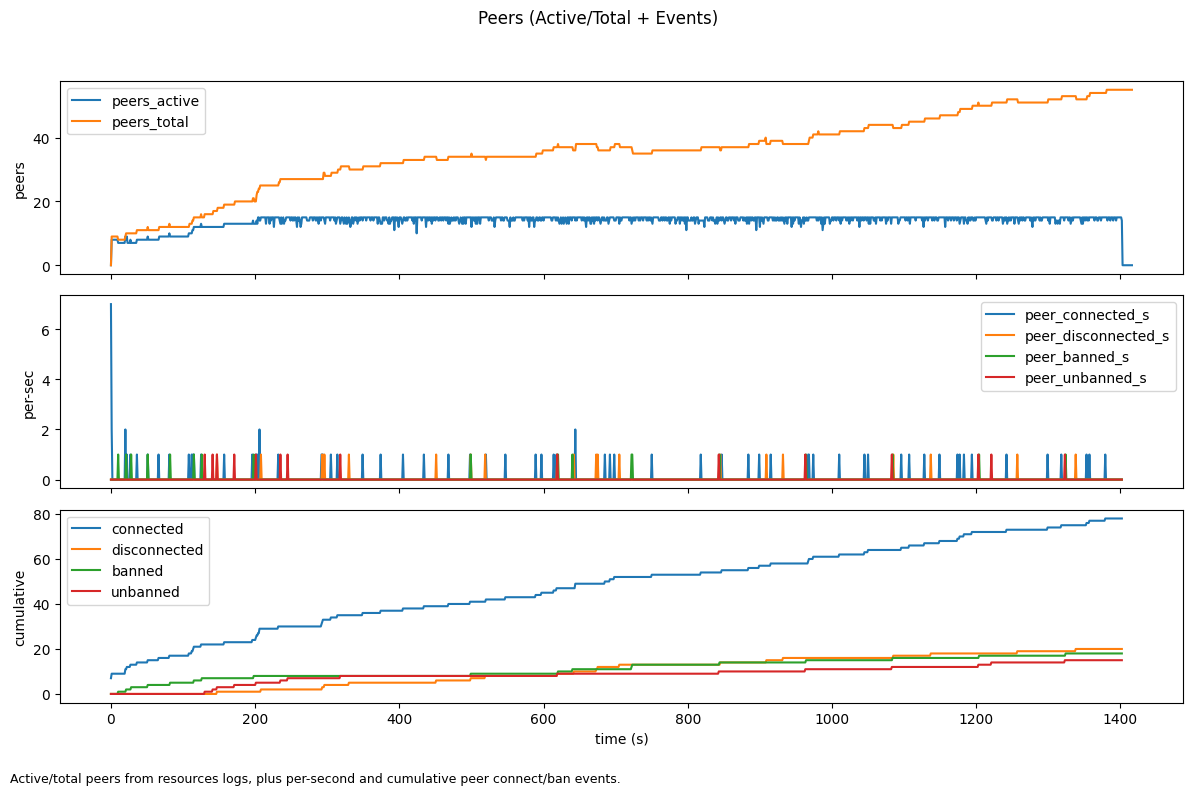

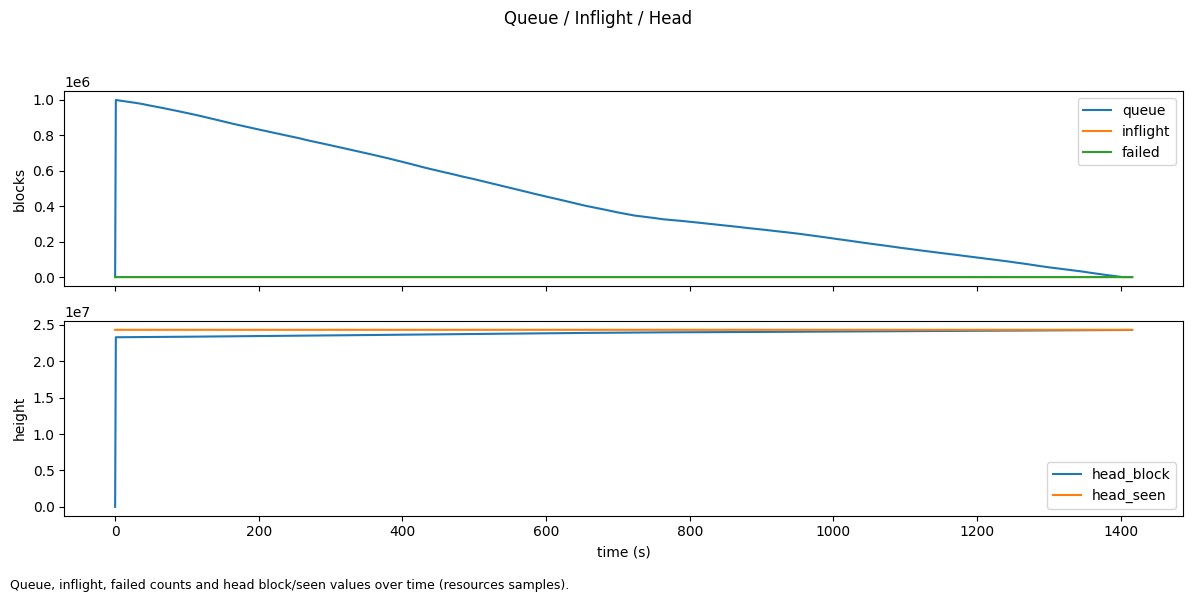

In [16]:
def _add_title_desc(fig, title: str, desc: str):
    fig.suptitle(title)
    fig.text(0.01, 0.01, desc, ha="left", va="bottom", fontsize=9)
    fig.tight_layout(rect=[0, 0.04, 1, 0.95])


def _plot_cpu_mem_disk(df: pd.DataFrame):
    if df.empty:
        print("No resources_sample data available.")
        return
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
    axes[0].plot(df["t_s"], df["cpu_busy_pct"], label="cpu_busy_pct")
    axes[0].plot(df["t_s"], df["cpu_iowait_pct"], label="cpu_iowait_pct")
    axes[0].set_ylabel("CPU %")
    axes[0].legend()

    axes[1].plot(df["t_s"], df["rss_gib"], label="rss_gib")
    axes[1].plot(df["t_s"], df["swap_gib"], label="swap_gib")
    axes[1].plot(df["t_s"], df["rss_anon_gib"], label="rss_anon_gib")
    axes[1].plot(df["t_s"], df["rss_file_gib"], label="rss_file_gib")
    axes[1].plot(df["t_s"], df["rss_shmem_gib"], label="rss_shmem_gib")
    axes[1].set_ylabel("GiB")
    axes[1].legend()

    axes[2].plot(df["t_s"], df["disk_read_mib_s"], label="disk_read_mib_s")
    axes[2].plot(df["t_s"], df["disk_write_mib_s"], label="disk_write_mib_s")
    axes[2].set_ylabel("MiB/s")
    axes[2].set_xlabel("time (s)")
    axes[2].legend()
    _add_title_desc(
        fig,
        "CPU / Memory / Disk I/O",
        "CPU busy/iowait %, memory (RSS/swap + breakdown) in GiB, disk read/write MiB/s over time (resources samples).",
    )
    plt.show()


def _plot_scheduler(df: pd.DataFrame):
    if df.empty:
        print("No scheduler_gauge_sample data available.")
        return
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
    axes[0].plot(df["t_s"], df["pending_total"], label="pending_total")
    axes[0].plot(df["t_s"], df["pending_main"], label="pending_main")
    axes[0].plot(df["t_s"], df["inflight"], label="inflight")
    axes[0].plot(df["t_s"], df["failed"], label="failed")
    axes[0].set_ylabel("blocks")
    axes[0].legend()

    axes[1].plot(df["t_s"], df["attempts"], label="attempts")
    axes[1].plot(df["t_s"], df["escalation_len"], label="escalation_len")
    axes[1].plot(df["t_s"], df["escalation_attempted"], label="escalation_attempted")
    axes[1].plot(df["t_s"], df["completed"], label="completed")
    axes[1].set_ylabel("count")
    axes[1].set_xlabel("time (s)")
    axes[1].legend()
    _add_title_desc(
        fig,
        "Scheduler State & Escalation",
        "Scheduler gauges: pending/inflight/failed blocks and escalation/attempt counts over time.",
    )
    plt.show()


def _plot_backlog(df: pd.DataFrame):
    if df.empty:
        print("No aggregated bins data available.")
        return
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
    axes[0].plot(df["t_s"], df["cum_fetch_blocks"], label="cum_fetch_blocks")
    axes[0].plot(df["t_s"], df["cum_processed_blocks"], label="cum_processed_blocks")
    axes[0].plot(df["t_s"], df["cum_db_blocks"], label="cum_db_blocks")
    axes[0].legend()
    axes[0].set_ylabel("blocks")

    axes[1].plot(df["t_s"], df["backlog_fetch_minus_process"], label="fetch_minus_process")
    axes[1].plot(df["t_s"], df["backlog_process_minus_write"], label="process_minus_write")
    axes[1].legend()
    axes[1].set_ylabel("backlog")
    axes[1].set_xlabel("time (s)")
    _add_title_desc(
        fig,
        "Pipeline Backlog",
        "Cumulative fetch/process/write totals and backlog deltas between stages.",
    )
    plt.show()


def _plot_db(df: pd.DataFrame, db_gauges: pd.DataFrame):
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
    if not db_gauges.empty:
        axes[0].plot(db_gauges["t_s"], db_gauges["buffer_len"], label="buffer_len")
        axes[0].plot(db_gauges["t_s"], db_gauges["compactions_inflight"], label="compactions_inflight")
        axes[0].plot(db_gauges["t_s"], db_gauges["compactions_total"], label="compactions_total")
        axes[0].legend()
        axes[0].set_ylabel("count")
    else:
        axes[0].text(0.5, 0.5, "No db_writer_gauge_sample data", ha="center")

    if not df.empty:
        axes[1].plot(df["t_s"], df["db_blocks"], label="db_blocks_s")
        axes[1].plot(df["t_s"], df["db_mib_s"], label="db_mib_s")
        axes[1].plot(df["t_s"], df["db_flush_avg_ms"], label="db_flush_avg_ms")
        axes[1].legend()
        axes[1].set_ylabel("rate / ms")
        axes[1].set_xlabel("time (s)")
    else:
        axes[1].text(0.5, 0.5, "No db_flush_end data", ha="center")
    _add_title_desc(
        fig,
        "DB Writer Throughput & Compactions",
        "Buffer length + compaction counts (gauges) with DB write throughput and flush latency.",
    )
    plt.show()




def _plot_compactions(compactions_df: pd.DataFrame, db_gauges: pd.DataFrame, resources_df: pd.DataFrame):
    if db_gauges.empty and compactions_df.empty:
        print("No compaction data available.")
        return

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

    # Gauge-based view (queued+running vs finished), sampled every ~10s.
    if not db_gauges.empty:
        g = db_gauges.sort_values("t_s").copy()
        g["compactions_done"] = (g["compactions_total"] - g["compactions_inflight"]).clip(lower=0)

        axes[0].plot(g["t_s"], g["compactions_total"], label="compactions_total")
        axes[0].plot(g["t_s"], g["compactions_inflight"], label="compactions_inflight")
        axes[0].plot(g["t_s"], g["compactions_done"], label="compactions_done")
        axes[0].set_ylabel("count")
        axes[0].legend()
    else:
        axes[0].text(0.5, 0.5, "No db_writer_gauge_sample data", ha="center")

    # Event-based view: shard compaction durations over time (scatter).
    if not compactions_df.empty:
        shard = compactions_df[compactions_df["kind"] == "shard"].copy()
        if not shard.empty and "duration_ms" in shard.columns:
            shard = shard.dropna(subset=["end_s", "duration_ms"])
        if not shard.empty:
            axes[1].scatter(
                shard["end_s"],
                shard["duration_ms"] / 1000.0,
                s=18,
                label="shard compaction duration (s)",
            )
            axes[1].set_ylabel("duration (s)")
            axes[1].set_xlabel("time (s)")
            axes[1].legend()
        else:
            axes[1].text(0.5, 0.5, "No shard compaction_end events", ha="center")
    else:
        axes[1].text(0.5, 0.5, "No compaction event data", ha="center")

    # Mark when we enter finalizing (typically: waiting for compactions).
    if not resources_df.empty and "status" in resources_df.columns:
        finals = resources_df[resources_df["status"] == "finalizing"]
        if not finals.empty:
            t0 = float(finals["t_s"].min())
            for ax in axes:
                ax.axvline(t0, color="black", linestyle="--", alpha=0.3)

    _add_title_desc(
        fig,
        "Compaction Progress",
        "Gauge-based compaction queue/progress plus shard compaction durations; dashed line marks entry into finalizing.",
    )
    plt.show()


def _plot_fetch(df: pd.DataFrame):
    if df.empty:
        print("No fetch data available.")
        return
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
    axes[0].plot(df["t_s"], df["fetch_blocks"], label="fetch_blocks_s")
    axes[0].plot(df["t_s"], df["fetch_mib_s"], label="fetch_mib_s")
    axes[0].plot(df["t_s"], df["fetch_missing"], label="fetch_missing_s")
    axes[0].legend()
    axes[0].set_ylabel("rate")

    axes[1].plot(df["t_s"], df["fetch_avg_ms"], label="fetch_avg_ms")
    axes[1].plot(df["t_s"], df["fetch_timeouts"], label="fetch_timeouts_s")
    axes[1].legend()
    axes[1].set_ylabel("ms / count")
    axes[1].set_xlabel("time (s)")
    _add_title_desc(
        fig,
        "Fetch Throughput & Latency",
        "Fetch blocks/MiB per sec, missing payloads, avg fetch latency, and timeouts.",
    )
    plt.show()


def _plot_processing(df: pd.DataFrame):
    if df.empty:
        print("No process_end data available.")
        return
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
    axes[0].plot(df["t_s"], df["processed_blocks"], label="processed_blocks_s")
    axes[0].plot(df["t_s"], df["processed_logs"], label="processed_logs_s")
    axes[0].legend()
    axes[0].set_ylabel("count")

    axes[1].plot(df["t_s"], df["process_avg_ms"], label="process_avg_ms")
    axes[1].legend()
    axes[1].set_ylabel("ms")
    axes[1].set_xlabel("time (s)")
    _add_title_desc(
        fig,
        "Processing Throughput & Latency",
        "Processed blocks/logs per sec and average processing latency.",
    )
    plt.show()


def _plot_speed(df: pd.DataFrame, db_window_s: int = 10):
    if df.empty:
        print("No aggregated bins data available.")
        return

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

    # Keep fetch/processed readable by putting DB write spikes on their own axis.
    axes[0].plot(df["t_s"], df.get("processed_blocks_s", 0), label="processed_blocks_s")
    axes[0].plot(df["t_s"], df.get("fetch_blocks_s", 0), label="fetch_blocks_s")
    axes[0].set_ylabel("blocks/s")
    axes[0].legend()

    # DB writes happen in big discrete batches (e.g. 500 blocks/flush), so per-second binning
    # quantizes the rate. Show the binned series + a windowed rate computed from raw counts.
    db_bin = df.get("db_blocks_s", 0)
    axes[1].plot(df["t_s"], db_bin, label="db_blocks_s (binned)", alpha=0.25)

    if "db_blocks" in df.columns and len(df) > 1:
        win_s = max(1, int(db_window_s))
        td = pd.to_timedelta(df["t_s"], unit="s")
        s = pd.Series(df["db_blocks"].values, index=td)
        db_win = s.rolling(f"{win_s}s").sum() / float(win_s)
        axes[1].plot(
            df["t_s"],
            db_win.values,
            label=f"db_blocks_s (rolling {win_s}s window)",
        )

        # Optional: also show how many flushes landed in the window.
        if "db_flushes" in df.columns:
            f = pd.Series(df["db_flushes"].values, index=td)
            flushes_win = f.rolling(f"{win_s}s").sum()
            ax2 = axes[1].twinx()
            ax2.plot(
                df["t_s"],
                flushes_win.values,
                label=f"db_flushes (rolling {win_s}s)",
                color="tab:gray",
                alpha=0.35,
            )
            ax2.set_ylabel("flushes / window")
            h1, l1 = axes[1].get_legend_handles_labels()
            h2, l2 = ax2.get_legend_handles_labels()
            axes[1].legend(h1 + h2, l1 + l2, loc="upper left")

    axes[1].set_ylabel("blocks/s")
    axes[1].set_xlabel("time (s)")

    _add_title_desc(
        fig,
        "Speed (Blocks/s)",
        "Processed/fetch per-second (binned). DB rate is shown separately as binned + rolling-window over db_blocks.",
    )
    plt.show()
def _plot_console_speed(resources_df: pd.DataFrame, smooth_window: int = 10):
    """Compute speed from benchmark resource log samples (delta processed / delta time)."""
    if resources_df.empty:
        print("No resources data available.")
        return
    if "processed" not in resources_df.columns:
        print("No 'processed' field in resources data.")
        return

    df = resources_df[["t_s", "processed"]].dropna().sort_values("t_s").copy()
    if len(df) < 2:
        print("Not enough resources samples to compute speed.")
        return

    dt = df["t_s"].diff()
    dp = df["processed"].diff()
    speed = dp / dt
    speed = speed.where((dt > 0) & (dp >= 0), 0)

    df["processed_s"] = speed
    df["processed_s_smooth"] = df["processed_s"].rolling(
        window=max(1, int(smooth_window)), min_periods=1
    ).mean()

    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.plot(df["t_s"], df["processed_s"], label="processed_s (raw)", alpha=0.25)
    ax.plot(
        df["t_s"],
        df["processed_s_smooth"],
        label=f"processed_s (rolling mean, {int(smooth_window)} samples)",
    )
    ax.set_ylabel("blocks/s")
    ax.set_xlabel("time (s)")
    ax.legend()
    _add_title_desc(
        fig,
        "Console-Derived Speed (Blocks/s)",
        "Speed computed from 'benchmark resources' samples: Δprocessed / Δtime.",
    )
    plt.show()
def _plot_peers(resources_df: pd.DataFrame, bins_df: pd.DataFrame):
    if resources_df.empty and bins_df.empty:
        print("No peer data available.")
        return
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 8))

    if not resources_df.empty and "peers_active" in resources_df.columns:
        axes[0].plot(resources_df["t_s"], resources_df["peers_active"], label="peers_active")
        axes[0].plot(resources_df["t_s"], resources_df["peers_total"], label="peers_total")
        axes[0].set_ylabel("peers")
        axes[0].legend()
    else:
        axes[0].text(0.5, 0.5, "No peers_active/peers_total data", ha="center")

    if not bins_df.empty:
        axes[1].plot(bins_df["t_s"], bins_df["peer_connected_s"], label="peer_connected_s")
        axes[1].plot(
            bins_df["t_s"], bins_df["peer_disconnected_s"], label="peer_disconnected_s"
        )
        axes[1].plot(bins_df["t_s"], bins_df["peer_banned_s"], label="peer_banned_s")
        axes[1].plot(bins_df["t_s"], bins_df["peer_unbanned_s"], label="peer_unbanned_s")
        axes[1].set_ylabel("per-sec")
        axes[1].legend()
    else:
        axes[1].text(0.5, 0.5, "No peer event data", ha="center")

    if not bins_df.empty:
        axes[2].plot(bins_df["t_s"], bins_df["peer_connected_cum"], label="connected")
        axes[2].plot(
            bins_df["t_s"], bins_df["peer_disconnected_cum"], label="disconnected"
        )
        axes[2].plot(bins_df["t_s"], bins_df["peer_banned_cum"], label="banned")
        axes[2].plot(bins_df["t_s"], bins_df["peer_unbanned_cum"], label="unbanned")
        axes[2].set_ylabel("cumulative")
        axes[2].set_xlabel("time (s)")
        axes[2].legend()
    else:
        axes[2].text(0.5, 0.5, "No peer event data", ha="center")

    _add_title_desc(
        fig,
        "Peers (Active/Total + Events)",
        "Active/total peers from resources logs, plus per-second and cumulative peer connect/ban events.",
    )
    plt.show()


def _plot_queue_head(df: pd.DataFrame):
    if df.empty:
        print("No resources_sample data available.")
        return
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
    axes[0].plot(df["t_s"], df["queue"], label="queue")
    axes[0].plot(df["t_s"], df["inflight"], label="inflight")
    axes[0].plot(df["t_s"], df["failed"], label="failed")
    axes[0].set_ylabel("blocks")
    axes[0].legend()

    axes[1].plot(df["t_s"], df["head_block"], label="head_block")
    axes[1].plot(df["t_s"], df["head_seen"], label="head_seen")
    axes[1].set_ylabel("height")
    axes[1].set_xlabel("time (s)")
    axes[1].legend()

    _add_title_desc(
        fig,
        "Queue / Inflight / Head",
        "Queue, inflight, failed counts and head block/seen values over time (resources samples).",
    )
    plt.show()


_plot_cpu_mem_disk(resources_df)
_plot_scheduler(scheduler_df)
_plot_backlog(bins_df)
_plot_db(bins_df, db_writer_df)
_plot_compactions(compactions_df, db_writer_df, resources_df)
_plot_fetch(bins_df)
_plot_processing(bins_df)
_plot_speed(bins_df)
_plot_console_speed(resources_df)
_plot_peers(resources_df, bins_df)
_plot_queue_head(resources_df)